In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
import nltk
import re
import os
from pathlib import Path
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import sys
import warnings

In [15]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
files = os.listdir()

In [3]:
files

['.ipynb_checkpoints',
 'DATA',
 'emotional_analysis.ipynb',
 'model',
 'test.txt',
 'train.txt',
 'val.txt']

In [4]:
train = pd.read_csv('train.txt', sep = ';', names = ['message', 'emot'])
test = pd.read_csv('test.txt', sep = ';', names = ['message', 'emot'])
val = pd.read_csv('val.txt', sep = ';', names = ['message', 'emot'])

In [5]:
df = pd.concat([train, test, val], axis = 0).reset_index(drop = True)

In [6]:
emotions = {emot:len(df[df['emot'] == emot]['emot']) for emot in set(df['emot'])}

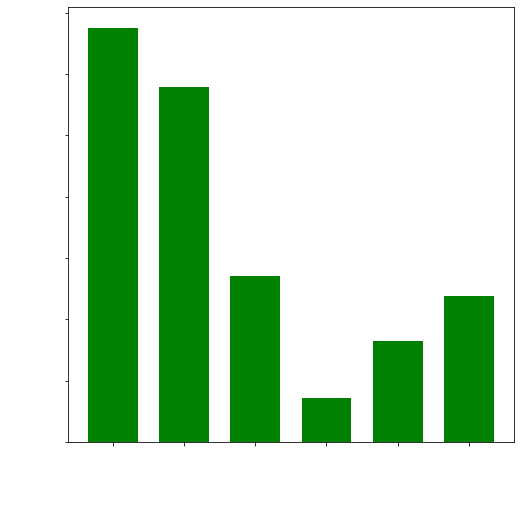

In [17]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.bar(emotions.keys(), emotions.values(), width = 0.7, color = 'green')
ax.set_xlabel('Emotion', fontsize = 20, color = 'white')
ax.set_ylabel('Amount', fontsize = 20, color = 'white')
ax.set_xticklabels(labels = emotions.keys(), color = 'white', fontsize = 12, rotation = 45)
ax.set_yticklabels(labels = emotions.values(), color = 'white', fontsize = 12)

plt.show()

In [19]:
train.shape

(16000, 2)

In [20]:
test.shape

(2000, 2)

In [21]:
val.shape

(2000, 2)

In [22]:
train

,message,emot
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


In [23]:
def text_processing(text):
    review = text.lower()
    review = re.sub('/s+', ' ', review)
    review = re.sub('/d', '', review)
    tokens = nltk.word_tokenize(review)
    
    lem = WordNetLemmatizer()
    tokens = [lem.lemmatize(word) for word in tokens if word not in stopwords.words('english')]
    
    sent = ' '.join(tokens)

    return sent

In [81]:
train = pd.concat([train['message'].apply(text_processing), train['emot']], axis = 1)
test = pd.concat([test['message'].apply(text_processing), test['emot']], axis = 1)
val = pd.concat([val['message'].apply(text_processing), val['emot']], axis = 1)

In [82]:
if not data_dir.exists():
    os.mkdir(data_dir)

with open(data_dir/'train.pkl', 'wb') as file:
    pickle.dump(train, file)
    
with open(data_dir/'test.pkl', 'wb') as file:
    pickle.dump(test, file)
    
with open(data_dir/'val.pkl', 'wb') as file:
    pickle.dump(val, file)


In [29]:
vocabulary_size = 5000 
sent_len = 40
features = 10

data_dir = Path.cwd()/'DATA'

In [25]:
def vectorizer(text, vocabulary_size = 5000, sent_len = 40):
    one_hot_rep = [one_hot(text, vocabulary_size )]
    vector = pad_sequences(one_hot_rep, maxlen = sent_len, padding = 'pre')
    return vector

In [26]:
all_classes = set(pd.concat([train['emot'], test['emot'], val['emot']], axis = 0))
class_mapper = {emot:number for number,emot in enumerate(all_classes)}

In [138]:
X_train = train['message'].apply(vectorizer)
X_train = np.array([i for i in X_train]).reshape(-1, sent_len)
y_train = tf.keras.utils.to_categorical(np.array(train['emot'].map(class_mapper)))

X_test = test['message'].apply(vectorizer)
X_test = np.array([i for i in X_test]).reshape(-1, sent_len)
y_test = tf.keras.utils.to_categorical(np.array(test['emot'].map(class_mapper)))

X_val = val['message'].apply(vectorizer)
X_val = np.array([i for i in X_val]).reshape(-1, sent_len)
y_val = tf.keras.utils.to_categorical(np.array(val['emot'].map(class_mapper)))

datas = {'X_train':X_train, 'y_train':y_train, 'X_test':X_test,
          'y_test':y_test, 'X_val':X_val, 'y_val':y_val}

for i in datas.keys():
    path = i + '.pkl'
    with open(data_dir/path, 'wb') as file:
        pickle.dump(datas[i], file)

In [27]:
def load_data():
        with open(data_dir/'X_train.pkl', 'rb') as file:
            X_train = pickle.load(file)
        with open(data_dir/'y_train.pkl', 'rb') as file:
            y_train = pickle.load(file)
    
        with open(data_dir/'X_test.pkl', 'rb') as file:
            X_test = pickle.load(file)
        with open(data_dir/'y_test.pkl', 'rb') as file:
            y_test = pickle.load(file)
            
        with open(data_dir/'X_val.pkl', 'rb') as file:
            X_val = pickle.load(file)
        with open(data_dir/'y_val.pkl', 'rb') as file:
            y_val = pickle.load(file)
        
        return X_train, y_train, X_test, y_test, X_val, y_val

In [30]:
try: 
    X_train *2
    y_train *2
except:
    X_train, y_train, X_test, y_test, X_val, y_val = load_data()

In [31]:
model = Sequential()
model.add(Embedding(input_dim = vocabulary_size, output_dim = features, input_length = sent_len))
model.add(Dropout(rate = 0.1))
model.add(LSTM(100, return_sequences = True, activation = 'relu'))
model.add(Dropout(rate = 0.1))
model.add(LSTM(50))
model.add(Dense(units = len(y_train[0]), activation = 'sigmoid'))

model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = 'accuracy')
reductor = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 5, verbose = 1)

In [32]:
model.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 64,
          epochs = 50, callbacks = [reductor])

Epoch 1/50
250/250 [==============================] - 116s 411ms/step - loss: 1.6110 - accuracy: 0.3340 - val_loss: 1.3505 - val_accuracy: 0.5180
Epoch 2/50
250/250 [==============================] - 82s 328ms/step - loss: 1.1228 - accuracy: 0.5827 - val_loss: 0.8484 - val_accuracy: 0.6550
Epoch 3/50
250/250 [==============================] - 45s 181ms/step - loss: 0.7215 - accuracy: 0.7163 - val_loss: 0.7073 - val_accuracy: 0.7370
Epoch 4/50
250/250 [==============================] - 45s 179ms/step - loss: 0.5351 - accuracy: 0.8092 - val_loss: 0.5335 - val_accuracy: 0.8135
Epoch 5/50
250/250 [==============================] - 50s 201ms/step - loss: 0.4130 - accuracy: 0.8606 - val_loss: 0.4714 - val_accuracy: 0.8375
Epoch 6/50
250/250 [==============================] - 42s 170ms/step - loss: 0.3287 - accuracy: 0.8897 - val_loss: 0.4515 - val_accuracy: 0.8475
Epoch 7/50
250/250 [==============================] - 42s 170ms/step - loss: 0.2776 - accuracy: 0.9038 - val_loss: 0.4458 - val_a

In [33]:
model.save(Path.cwd()/'model')

INFO:tensorflow:Assets written to: A:\ML\NLP\Emotional_analysis\model\assets


INFO:tensorflow:Assets written to: A:\ML\NLP\Emotional_analysis\model\assets


In [35]:
def validation(X, y, model, what_data, class_mapper):
    print('___________________{0} DATA___________________'.format(what_data.upper()))
    class_mapper = {class_mapper[key]: key for key in class_mapper.keys()}
    y_pred = model.predict(X)
    y = [i.argmax() for i in y]
    y_pred= [i.argmax() for i in y_pred]

    all_classes = set(y)
    
    class_index = {_class:[number for number,i in enumerate(y) if i == _class] for _class in all_classes}    
        
    def class_accuracy(_class, _index, y, y_pred, class_mapper):
        y = [y[i] for i in _index]
        y_pred = [y_pred[i] for i in _index]

        accuracy = round(accuracy_score(y, y_pred), ndigits = 2, )*100
        print('For {0} accuracy = {1}%'.format(class_mapper[_class].upper(), accuracy))
            
    for i in all_classes:
        class_accuracy(i, class_index[i], y, y_pred, class_mapper)
            
    
    
    
    accuracy = round(accuracy_score(y, y_pred), ndigits = 2, )*100
    precision = round(precision_score(y, y_pred, average = 'weighted'), ndigits = 2)*100
    recall = round(recall_score(y, y_pred, average = 'weighted'), ndigits = 2)*100
    f1 = round(f1_score(y, y_pred, average = 'weighted'), ndigits = 2)
    
    print('Accuracy = {0}%'.format(accuracy))
    print('Precision = {0}%'.format(precision))
    print('Recall = {0}%'.format(recall))
    print('F1-score = {0}'.format(f1))
    print('_______________________________________________')
    
    
    

In [36]:
validation(X_train, y_train, model, 'train', class_mapper)
validation(X_test, y_test, model, 'test', class_mapper)
validation(X_val, y_val, model, 'validation', class_mapper)

___________________TRAIN DATA___________________
For JOY accuracy = 96.0%
For SADNESS accuracy = 97.0%
For ANGER accuracy = 93.0%
For SURPRISE accuracy = 86.0%
For LOVE accuracy = 99.0%
For FEAR accuracy = 98.0%
Accuracy = 97.0%
Precision = 97.0%
Recall = 97.0%
F1-score = 0.97
_______________________________________________
___________________TEST DATA___________________
For JOY accuracy = 75.0%
For SADNESS accuracy = 87.0%
For ANGER accuracy = 81.0%
For SURPRISE accuracy = 64.0%
For LOVE accuracy = 91.0%
For FEAR accuracy = 87.0%
Accuracy = 86.0%
Precision = 86.0%
Recall = 86.0%
F1-score = 0.86
_______________________________________________
___________________VALIDATION DATA___________________
For JOY accuracy = 75.0%
For SADNESS accuracy = 84.0%
For ANGER accuracy = 79.0%
For SURPRISE accuracy = 77.0%
For LOVE accuracy = 94.0%
For FEAR accuracy = 86.0%
Accuracy = 86.0%
Precision = 86.0%
Recall = 86.0%
F1-score = 0.86
_______________________________________________
